In [2]:
import pandas as pd
import numpy as np
import os
from mplsoccer.pitch import Pitch

# Load data

Load event data

In [3]:
df_events_wyscout = pd.read_parquet(os.path.join('..', 'data', 'wyscout', 'event.parquet'))
df_events_statsbomb = pd.read_parquet(os.path.join('..', 'data', 'statsbomb', 'event.parquet'))

Get match dataframe for full seasons in Wyscout data

In [4]:
df_match_wyscout = pd.read_parquet(os.path.join('..', 'data', 'wyscout', 'match.parquet'))
df_match_wyscout = df_match_wyscout[df_match_wyscout.competition_name.isin(['Premier League', 'Ligue 1', 
                                                                            'Bundesliga', 'Serie A', 'La Liga'])].copy()
df_match_wyscout_overlap = pd.read_parquet(os.path.join('..', 'data', 'wyscout', 'match_overlap.parquet'))
df_match_wyscout_overlap = df_match_wyscout_overlap[df_match_wyscout_overlap.competition_name == 'La Liga'].copy()
df_match = pd.concat([df_match_wyscout, df_match_wyscout_overlap])

Get a match dataframe for the overlapping games from the Statsbomb data

In [5]:
df_match_statsbomb = pd.read_parquet(os.path.join('..', 'data', 'statsbomb', 'match.parquet'))
mask_la_liga = (df_match_statsbomb.competition_name == 'La Liga') & (df_match_statsbomb.season_name == '2017/2018')
df_match_statsbomb = df_match_statsbomb[mask_la_liga].copy()

# Get a match id/ team id lookup for overlapping games

In [6]:
cols = ['match_id', 'home_team_id', 'home_team_name', 'away_team_id', 'away_team_name']
df_overlap_ids = df_match_wyscout_overlap[cols].merge(df_match_statsbomb[cols],
                                                      on=['home_team_name', 'away_team_name'], suffixes=['_wyscout', ''])
df_home = df_overlap_ids[['home_team_id_wyscout', 'home_team_id']].copy()
df_away = df_overlap_ids[['away_team_id_wyscout', 'away_team_id']].copy()
df_home.rename({'home_team_id_wyscout': 'team_id_wyscout', 'home_team_id': 'team_id'}, axis=1, inplace=True)
df_away.rename({'away_team_id_wyscout': 'team_id_wyscout', 'away_team_id': 'team_id'}, axis=1, inplace=True)
df_team_overlap = pd.concat([df_home, df_away])
df_team_overlap.drop_duplicates(inplace=True)
df_match_overlap = df_overlap_ids[['match_id', 'match_id_wyscout']]

# Add a goal flag

In [7]:
df_events_statsbomb['goal'] = df_events_statsbomb.outcome_name == 'Goal'

# Filter events dataframes to only include shots from the 5 big league matches and specific columns

In [8]:
mask_match = df_events_wyscout.match_id.isin(df_match_wyscout.match_id)
mask_shot = df_events_wyscout.subEventName.isin(['Penalty', 'Free kick shot', 'Shot'])
cols = ['match_id', 'id', 'subEventName', 'matchPeriod', 'eventSec', 'team_id', 'x', 'y', 'goal']
df_events_wyscout = df_events_wyscout.loc[mask_match & mask_shot, cols].copy()

In [9]:
mask_match = df_events_statsbomb.match_id.isin(df_match_statsbomb.match_id)
mask_shot = df_events_statsbomb.type_name == 'Shot'
cols = ['match_id', 'id', 'period', 'timestamp', 'team_id', 'x', 'y', 'shot_statsbomb_xg', 'goal']
df_events_statsbomb = df_events_statsbomb.loc[mask_match & mask_shot, cols].copy()

In [10]:
df_events_wyscout.match_id.nunique() + df_events_statsbomb.match_id.nunique()

1829

# Format the dataframes

Add wyscout match/ team ids to statsbomb data

In [11]:
df_events_statsbomb = df_events_statsbomb.merge(df_match_overlap)
df_events_statsbomb = df_events_statsbomb.merge(df_team_overlap)
df_events_statsbomb.drop('match_id', axis=1, inplace=True)
df_events_statsbomb.drop('team_id', axis=1, inplace=True)
df_events_statsbomb = df_events_statsbomb.rename({'match_id_wyscout': 'match_id', 'team_id_wyscout': 'team_id'}, axis=1)

Add on wyscout xg

In [12]:
df_xg = pd.read_parquet(os.path.join('..', 'data', 'modelling', 'xg_shap.parquet'))
df_xg = df_xg.loc[df_xg.wyscout_id.notnull(), ['match_id', 'wyscout_id', 'xg']].rename({'wyscout_id': 'id'}, axis=1)
df_events_wyscout = df_events_wyscout.merge(df_xg, on=['match_id', 'id'], how='left')
df_events_wyscout.loc[df_events_wyscout.subEventName == 'Penalty', 'xg'] = 0.76

Do not have xg for some outliers

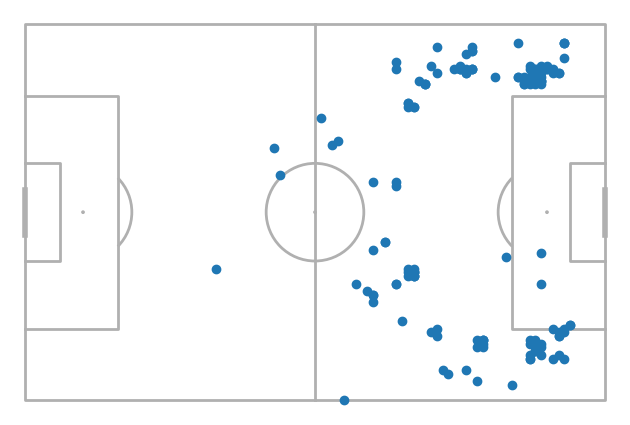

In [13]:
pitch = Pitch(pitch_type='wyscout')
fig, ax = pitch.draw()
mask_no_xg = df_events_wyscout.xg.isnull()
pitch.scatter(df_events_wyscout[mask_no_xg].x, df_events_wyscout[mask_no_xg].y, ax=ax)

Set xg to 0.015 if missing (1.5%)

In [14]:
df_events_wyscout.loc[df_events_wyscout.xg.isnull(), 'xg'] = 0.015

Tidy up dataframes for consistent formats

In [15]:
df_events_statsbomb['eventSec'] = df_events_statsbomb.timestamp.apply(lambda x: x.minute * 60 + x.second + x.microsecond / 1000000)
df_events_statsbomb.rename({'shot_statsbomb_xg': 'xg'}, axis=1, inplace=True)
df_events_statsbomb.drop('timestamp', axis='columns', inplace=True)

In [16]:
df_events_wyscout.rename({'matchPeriod': 'period'}, axis=1, inplace=True)
df_events_wyscout['period'] = df_events_wyscout.period.map({'1H': 1, '2H': 2})

Combine the dataframes

In [17]:
df_events_wyscout['data'] = 'wyscout'
df_events_statsbomb['data'] = 'statsbomb'
df_events = pd.concat([df_events_wyscout, df_events_statsbomb])

Sort the dataframe

In [18]:
df_events.sort_values(['match_id', 'period', 'eventSec'], inplace=True)

# Add a home_or_away column to the events dataframe:
home_shots when the shot is taken by the home team <br>
away_shots when the shot is taken by the away team

In [19]:
# first merge on the the home_team_id for each match from the df_match dataframe
df_events = df_events.merge(df_match[['match_id', 'home_team_id']], on='match_id', validate='m:1', how='left')
# then create a home_or_away column by comparing the home_team_id with the team_id
mask_home = df_events.team_id == df_events.home_team_id
df_events['home_or_away'] = np.where(mask_home, 'home_shots', 'away_shots')
df_events.drop('home_team_id', axis='columns', inplace=True)

# Show matches where one team didn't get a single shot on target.

In [20]:
# group on match id and show matches wher there is only one team with a shot event
num_teams_per_match = df_events.groupby('match_id').team_id.nunique()
num_teams_per_match[num_teams_per_match==1].index.tolist()

[2500013, 2576281]

# We are going to make the analysis easier by adding a fake shot with 0xG where the team didn't get a shot on target

Note for the purpose of the simulation 0xG will mean that the fake shot will never count as a goal. As the xG value will be lower than the simulated proability.

In [21]:
len(df_events)

43085

In [22]:
# first we merge the number of shots for each team on to the df_match dataframe
df_shots_per_team = (df_events.groupby(['match_id', 'home_or_away']).team_id.count()
                     .reset_index()
                     .pivot(index='match_id', columns='home_or_away', values='team_id')
                     .reset_index()
                     .fillna(0))
df_match = df_match.merge(df_shots_per_team, on='match_id', how='left', validate='1:1')
# we create a fake shot record for each match where the away team has no shots
df_away_missing =  df_match.loc[df_match.away_shots==0, ['match_id', 'away_team_id']].copy()
df_away_missing['xg'] = 0.0
df_away_missing['home_or_away'] = 'away_shots'
df_away_missing.rename({'away_team_id':'team_id'}, axis=1, inplace=True)
# we also create a fake shot record where the home team has no shots
df_home_missing = df_match.loc[df_match.home_shots==0, ['match_id', 'home_team_id']].copy()
df_home_missing['xg'] = 0.0
df_home_missing['home_or_away'] = 'home_shots'
df_home_missing.rename({'home_team_id': 'team_id'},axis=1,inplace=True)
# combine the missing shot information and add one to the max possession to make it unique
df_missing_shots = pd.concat([df_home_missing, df_away_missing], axis=0)
# putting in an eventSec/ period (it doesn't matter what this is as the xG is zero)
df_missing_shots['eventSec'] = 0
df_missing_shots['period'] = 1
# add the fake shot data to the event dataframe and sort it into the right order
df_events = pd.concat([df_missing_shots, df_events])
df_events.sort_values(['match_id', 'eventSec'], inplace=True)

In [23]:
len(df_events)

43087

# Create a shot possession group (i.e. shots within 15 seconds of each other are in the same group)

In [24]:
df_events['eventSec_shift'] = df_events.groupby(['match_id', 'period']).eventSec.shift(1)
df_events['new_shot_sequence'] = (((df_events['eventSec'] - df_events['eventSec_shift']) > 15) |
                                  (df_events.match_id != df_events.match_id.shift(1)) |
                                  (df_events.period != df_events.period.shift(1)))
df_events['possession'] = df_events.new_shot_sequence.cumsum()
df_events.drop(['eventSec_shift', 'new_shot_sequence'], axis=1, inplace=True)

In [25]:
df_events.head()

,match_id,team_id,xg,home_or_away,eventSec,period,id,subEventName,x,y,goal,data,possession
0,2499719,1609.0,0.126841,home_shots,94.595788,1,177959212,Shot,88.0,41.0,True,wyscout,1
1,2499719,1631.0,0.087871,away_shots,179.854785,1,177959247,Shot,85.0,52.0,False,wyscout,2
15,2499719,1609.0,0.054885,home_shots,231.514689,2,177960206,Shot,71.0,64.0,False,wyscout,3
2,2499719,1631.0,0.385387,away_shots,254.745027,1,177959280,Shot,96.0,52.0,True,wyscout,4
16,2499719,1631.0,0.179171,away_shots,340.664542,2,177960274,Shot,92.0,50.0,False,wyscout,5


# Free up memory

In [26]:
del df_away, df_away_missing, df_events_statsbomb, df_events_wyscout, df_home, df_match_overlap, df_match_statsbomb, df_match_wyscout, df_match_wyscout_overlap, df_missing_shots, df_overlap_ids, df_shots_per_team, df_team_overlap, df_xg

# Simulation parameters

In [27]:
np.random.seed(42)
n_sims = 10000
sim_columns = np.arange(n_sims)

# Show events where the possession has more than one team shooting

There a few shot sequences where more than one team has a shot. This impacts our simulation. If there is a goal, I want to model it so the rest of the possession didn't happen and the second team didn't have a chance to shoot. This is to mimic a real match where if one team scores, there is a kick-off and the possession ends.

In [28]:
num_teams_per_possession_sequence = df_events.groupby('possession').team_id.nunique()
num_teams_per_possession_sequence[num_teams_per_possession_sequence>1].index

Index([  339,  1190,  2590,  3017,  3122,  3181,  4521,  6220,  6323,  6809,
        7543,  8150,  8474,  9081,  9213,  9311,  9420, 10272, 10923, 11277,
       12539, 13096, 15375, 15591, 16108, 17979, 18114, 18355, 18404, 19368,
       19374, 19732, 20118, 20365, 20797, 22845, 22910, 23594, 23959, 24026,
       24328, 24617, 24890, 24928, 25383, 25706, 26959, 28247, 28540, 28957,
       29102, 30720, 30742, 31258, 32155, 33531, 34573, 34871, 35155, 36834,
       37059, 38322, 39664],
      dtype='int64', name='possession')

# Simulate the goals for each shot and sum up the number of goals for each team in a match

First simulate the goals. We are going to create an array of uniform random numbers between 0-1. If the random number is greater than the xG we do not count it as a goal (=0). If the random number is less than the xG we count it as a goal (=1). For example, for a shot with xG of 0.17 then there is a 17% chance of a goal, we count it as a goal if the random number is <= 0.17.

In [29]:
n_shots = len(df_events)
simulated_probabilities = np.random.uniform(size=(n_shots, n_sims))
simulated_goals = np.where(simulated_probabilities > df_events.xg.values.reshape(-1, 1), 0, 1)

In [30]:
simulated_goals.shape

(43087, 10000)

Create a dataframe of simulated goals and if there is more than one simulated goal in a unique possession keep the first and set the others to zero. The dataframe is n_shots length by n_sims wide.

In [31]:
df_simulated_goals = pd.concat([df_events[['possession']],
                                pd.DataFrame(simulated_goals, index=df_events.index)],
                               axis=1)
# here we are setting the first goal in the possession to 1 and the rest of the goals in the possession to 0
df_simulated_goals = df_simulated_goals.groupby('possession').cumsum()
df_simulated_goals = pd.DataFrame(np.where(df_simulated_goals > 1, 0, df_simulated_goals), index=df_events.index)

In [32]:
df_simulated_goals.shape

(43087, 10000)

Next we sum the number of simulated goals for each team in the match. The dataframe is now (n_teams*2) length by n_sims wide

In [33]:
# we add on the match id and home_or_away flag and sum the goals in the game for each team (home_shots/ away_shots)
df_simulated_goals = pd.concat([df_events[['match_id', 'home_or_away']], df_simulated_goals],axis=1)
df_simulated_goals = df_simulated_goals.groupby(['match_id', 'home_or_away'])[sim_columns].sum()
df_simulated_goals.reset_index(inplace=True)

In [34]:
df_simulated_goals.shape

(3652, 10002)

# Recreate the League Tables

In [35]:
# create some columns used to create the table stats: goal difference, win, lose, draw
df_match['home_goal_diff'] = df_match['home_score'] - df_match['away_score']
df_match['home_win'] = df_match.home_score > df_match.away_score
df_match['home_lose'] = df_match.home_score < df_match.away_score
df_match['away_goal_diff'] = df_match['away_score'] - df_match['home_score']
df_match['away_win'] = df_match.away_score > df_match.home_score
df_match['away_lose'] = df_match.away_score < df_match.home_score
df_match['draw'] = df_match.away_score == df_match.home_score

In [36]:
mask_home_win = df_match.home_score > df_match.away_score
mask_away_win = df_match.away_score > df_match.home_score
mask_draw = df_match.away_score == df_match.home_score
df_match.loc[mask_home_win,'home_points'] = 3
df_match.loc[mask_home_win,'away_points'] = 0
df_match.loc[mask_away_win,'away_points'] = 3
df_match.loc[mask_away_win,'home_points'] = 0
df_match.loc[mask_draw,'home_points'] = 1
df_match.loc[mask_draw,'away_points'] = 1

In [37]:
league_tables = []
for competition in ['Premier League', 'Ligue 1', 'Bundesliga', 'Serie A', 'La Liga']:
    match_ids = df_match[(df_match.competition_name==competition)].match_id
    # create a dataframe of away results
    away_cols = ['away_team_name','away_points','away_goal_diff','away_win','draw',
                 'away_lose','away_score','home_score']
    away_rename = {'away_points':'points','away_team_name':'team_name',
                   'away_goal_diff':'goal_difference','away_win':'win','away_lose':'lose',
                   'away_score':'goals_for','home_score':'goals_against'}
    df_away = df_match.loc[df_match.match_id.isin(match_ids), away_cols]
    # create a dataframe of home results
    home_cols = ['home_team_name','home_points','home_goal_diff','home_win','draw','home_lose',
                 'home_score','away_score']
    home_rename = {'home_points':'points','home_team_name':'team_name',
                   'home_goal_diff':'goal_difference','home_win':'win','home_lose':'lose',
                   'home_score':'goals_for','away_score':'goals_against'}
    df_home = df_match.loc[df_match.match_id.isin(match_ids),home_cols]
    # combine to get the whole league results
    df_league = pd.concat([df_away.rename(away_rename,axis=1),
                           df_home.rename(home_rename,axis=1)])
    # add the number of games played to the team stats to create a df_table dataframe
    stats_cols = ['win','draw','lose','goals_for','goals_against','goal_difference','points']
    df_table = (df_league.groupby('team_name')[stats_cols].sum())
    df_played = df_league.team_name.value_counts()
    df_played.name = 'played'
    df_table = pd.concat([df_played, df_table],axis=1,sort=False)
    # sort by the criteria for winning league, note there is one final criteria head-for-head not implemented here
    df_table.sort_values(['points','goal_difference','goals_for','win'],ascending=False,inplace=True)
    # index as team rank rather than team name
    df_table.reset_index(inplace=True)
    df_table.index = df_table.index+1
    # set columns to easy names
    df_table.columns = ['Team','Played','Won','Drawn','Lost','For','Against','Goal Difference','Points']
    # columns to integers (some are float)
    df_table[df_table.columns[1:]] = df_table[df_table.columns[1:]].astype(int)   
    # add position to dataframe
    df_table.index.name = 'position'
    df_table.reset_index(inplace=True)
    league_tables.append(df_table)

In La liga and seria A. The fules for classification are different 1) Points; 2) Head-to-head points; 3) Head-to-head goal difference; 4) Goal difference; 5) Goals scored

I.e. head to head results get considered before goal difference so the tables are in the wrong order.

Manually set them in the right order

In [38]:
df_spain = league_tables[4]
df_spain.loc[df_spain.Team == 'Espanyol', 'position'] = 11
df_spain.loc[df_spain.Team == 'Real Sociedad', 'position'] = 12
df_spain.loc[df_spain.Team == 'Celta Vigo', 'position'] = 13
df_spain.sort_values('position', inplace=True)
league_tables[4] = df_spain

In [39]:
df_italy = league_tables[3]
df_italy.loc[df_italy.Team == 'FC Internazionale Milano', 'position'] = 4
df_italy.loc[df_italy.Team == 'SS Lazio', 'position'] = 5
df_italy.loc[df_italy.Team == 'AC Chievo Verona', 'position'] = 13
df_italy.loc[df_italy.Team == 'Udinese Calcio', 'position'] = 14
df_italy.sort_values('position', inplace=True)
league_tables[3] = df_italy

# Calculate the average points and add to the df_match dataframe.

In [40]:
df_match['away_points_sim'] = (df_match.away_win * 3 + df_match.draw)
df_match['home_points_sim'] = (df_match.home_win * 3 + df_match.draw)

# Add the goal difference, e.g. the probability that the home team is -5 goals down to the df_match dataframe

In [41]:
# first get the goal difference in relation to the home team
df_goals_home = (df_simulated_goals[df_simulated_goals.home_or_away == 'home_shots']
                 .drop('home_or_away', axis=1)
                 .set_index('match_id'))
df_goals_away = (df_simulated_goals[df_simulated_goals.home_or_away == 'away_shots']
                 .drop('home_or_away', axis=1)
                 .set_index('match_id'))

# Simuate the league points

In [42]:
home_win = df_goals_home > df_goals_away
away_win = df_goals_away > df_goals_home
draw = df_goals_home == df_goals_away
# calculate home win points
home_win = home_win.merge(df_match[['match_id', 'home_team_name', 'competition_name']],
                          left_index=True, right_on='match_id').rename({'home_team_name': 'team_name'}, axis=1)
points_home = home_win.groupby(['team_name', 'competition_name'])[sim_columns].sum() * 3
# calculate away win points
away_win = away_win.merge(df_match[['match_id', 'away_team_name', 'competition_name']],
                          left_index=True, right_on='match_id').rename({'away_team_name': 'team_name'}, axis=1)
points_away = away_win.groupby(['team_name', 'competition_name'])[sim_columns].sum() * 3
# calculate draw points for home team
draw1 = draw.merge(df_match[['match_id', 'home_team_name', 'competition_name']],
                   left_index=True, right_on='match_id').rename({'home_team_name': 'team_name'}, axis=1)
points_draw1 = draw1.groupby(['team_name', 'competition_name'])[sim_columns].sum()
# calculate draw points for away team
draw2 = draw.merge(df_match[['match_id', 'away_team_name', 'competition_name']],
                   left_index=True, right_on='match_id').rename({'away_team_name': 'team_name'}, axis=1)
points_draw2 = draw2.groupby(['team_name', 'competition_name'])[sim_columns].sum()
# add together for all points for each team
all_points = points_home + points_away + points_draw1 + points_draw2
all_points.reset_index(inplace=True)

In [43]:
# simulate how many points each team gets
league_sims_points = []
for i, league in enumerate(['Premier League', 'Ligue 1', 'Bundesliga', 'Serie A', 'La Liga']):
    df_league_actual = league_tables[i]
    df_league_points = all_points[all_points.competition_name == league].drop('competition_name', axis=1)
    df_league_points = df_league_points.merge(df_league_actual[['Team', 'position']],
                                              left_on='team_name', right_on='Team', how='left')
    df_league_points.sort_values('position', inplace=True)
    df_league_points.drop(['Team', 'position'], axis=1, inplace=True)
    df_league_points.set_index('team_name', inplace=True)
    league_sims_points.append(df_league_points)

In [44]:
df_match.competition_name.value_counts()

competition_name
Premier League    380
Ligue 1           380
Serie A           380
La Liga           380
Bundesliga        306
Name: count, dtype: int64

In [45]:
# simulate the league position probabiliies
with pd.ExcelWriter(os.path.join('..', 'figures', '31-35_simulated_league_table.xlsx')) as writer: 
    sim_position = []
    for i, competition in enumerate(league_sims_points):
        df_pos = competition.rank(axis=0, ascending=False, method='first').T
        df_pos = df_pos.apply(pd.Series.value_counts)
        df_pos.fillna(0, inplace=True)
        df_pos = np.round(df_pos / 100, 0).astype(np.int32)
        df_pos.index.name = 'position'
        df_pos = df_pos.T
        df_pos.columns = list(range(1, len(df_pos.columns) + 1))
        df_pos.index.name = ''
        df_pos = df_pos.style.background_gradient(cmap='viridis')
        name = ['premier_league', 'ligue_1', 'bundesliga', 'serie_a', 'la_liga'][i]
        df_pos.to_excel(writer, sheet_name=name)
        sim_position.append(df_pos)

In [46]:
sim_position[0]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
,,,,,,,,,,,,,,,,,,,,
Manchester City,88,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Manchester United,0,3,11,20,21,19,12,6,3,2,1,1,0,0,0,0,0,0,0,0
Tottenham Hotspur,2,21,38,20,11,6,2,1,0,0,0,0,0,0,0,0,0,0,0,0
Liverpool,10,58,22,7,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Chelsea,0,3,10,21,23,20,12,6,3,2,1,0,0,0,0,0,0,0,0,0
Arsenal,0,5,15,24,23,16,8,4,2,1,0,0,0,0,0,0,0,0,0,0
Burnley FC,0,0,0,0,0,1,2,3,5,6,7,8,9,10,10,10,10,9,7,5
Everton,0,0,0,0,1,3,6,9,11,12,10,10,9,7,6,5,4,3,2,1
Leicester City,0,0,1,2,4,8,13,15,14,11,8,7,5,4,3,2,1,1,0,0


In [47]:
sim_position[1]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
,,,,,,,,,,,,,,,,,,,,
Paris Saint-Germain FC,89,9,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AS Monaco,0,6,13,19,16,11,9,7,6,4,3,3,1,1,1,0,0,0,0,0
Olympique Lyonnais,4,38,30,13,7,3,2,1,1,0,0,0,0,0,0,0,0,0,0,0
Olympique de Marseille,6,39,30,12,6,3,2,1,1,0,0,0,0,0,0,0,0,0,0,0
Stade Rennais FC,0,1,3,7,9,9,9,9,9,8,8,7,6,5,4,3,2,1,0,0
FC Girondins de Bordeaux,0,3,7,13,12,13,11,9,8,6,5,4,3,2,2,1,1,0,0,0
AS Saint-Étienne,0,0,2,4,7,8,9,9,9,9,8,8,7,6,5,4,2,1,0,0
O.G.C. Nice Côte d'Azur,0,1,4,8,10,10,10,9,9,8,7,6,5,4,3,2,1,1,0,0
FC Nantes,0,1,3,7,9,10,10,9,9,9,7,7,6,5,4,3,2,1,0,0


In [48]:
sim_position[2]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
,,,,,,,,,,,,,,,,,,
FC Bayern München,72,20,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FC Schalke 04,0,2,4,10,12,12,11,10,8,7,6,5,4,3,3,2,1,0
TSG 1899 Hoffenheim,1,5,12,19,16,13,9,7,6,4,3,2,1,1,1,0,0,0
Borussia Dortmund,14,36,26,12,6,3,2,1,0,0,0,0,0,0,0,0,0,0
TSV Bayer 04 Leverkusen,12,30,31,13,6,3,2,1,0,0,0,0,0,0,0,0,0,0
Rasen Ballsport Leipzig,1,4,9,17,17,12,11,8,6,5,3,3,2,1,1,1,0,0
VfB Stuttgart 1893,0,0,1,4,6,7,9,9,10,9,9,8,7,6,5,4,3,1
Eintracht Frankfurt,0,1,3,7,10,11,11,10,8,8,7,6,4,4,3,2,2,1
Borussia VfL Mönchengladbach,0,1,2,4,6,8,9,9,9,9,8,7,7,6,5,4,3,2


In [49]:
sim_position[3]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
,,,,,,,,,,,,,,,,,,,,
Juventus,12,18,18,15,13,9,7,4,2,1,0,0,0,0,0,0,0,0,0,0
SSC Napoli,50,23,13,7,4,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
AS Roma,7,13,16,17,14,12,9,6,3,1,1,0,0,0,0,0,0,0,0,0
FC Internazionale Milano,4,7,11,13,16,15,14,10,6,3,1,0,0,0,0,0,0,0,0,0
SS Lazio,1,4,6,9,12,14,16,16,10,6,3,2,1,0,0,0,0,0,0,0
AC Milan,3,6,9,12,13,16,15,12,7,3,2,1,0,0,0,0,0,0,0,0
Atalanta Bergamasca Calcio,21,23,18,13,9,7,4,2,1,0,0,0,0,0,0,0,0,0,0,0
ACF Fiorentina,2,5,7,11,14,16,16,14,8,4,2,1,0,0,0,0,0,0,0,0
Torino FC,0,0,0,1,2,3,5,9,17,17,15,12,8,5,3,2,1,1,0,0


In [50]:
sim_position[4]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
,,,,,,,,,,,,,,,,,,,,
Barcelona,44,50,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Atlético Madrid,0,2,14,13,11,10,8,8,6,5,5,4,3,3,2,2,1,1,0,0
Real Madrid,55,41,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Valencia,0,1,10,11,10,10,9,8,7,6,6,5,5,3,3,2,2,1,1,0
Villarreal,0,0,2,3,4,5,6,7,7,7,7,7,7,7,7,7,5,5,4,2
Real Betis,0,0,1,2,3,4,4,5,6,6,7,7,8,8,8,8,8,6,5,3
Sevilla,0,3,22,16,12,10,8,6,5,4,3,3,2,2,1,1,1,0,0,0
Getafe,0,1,12,12,12,10,9,8,7,6,5,4,4,3,2,2,1,1,0,0
Eibar,0,0,4,6,6,7,7,8,8,8,7,7,6,6,5,5,4,3,2,1
